In [11]:
%reset

In [12]:
import numpy as np
import tensorflow as tf
import importlib
import end_to_end_model
importlib.reload(end_to_end_model)
import sionna as sn
from sionna.phy.mapping import Constellation
from sionna.phy import config, dtypes, Block
from end_to_end_model import EndToEndSystem_bitwise_PAS, normalize_constellation, plot_constellation_wlabels, symbol_points_qam64


In [13]:
devices = tf.config.list_physical_devices('GPU')
print(len(devices))

1


In [14]:
###############################
# Train function
###############################
N = 64
num_bits_symbol = np.log2(N)
constellation_orig = Constellation("pam", num_bits_per_symbol=6)
tau = 10
parity_k = 0
use_upsampling_filtering = True
uniform_input = True

device = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"
model = EndToEndSystem_bitwise_PAS(N, parity_k, symbol_points_qam64, device, constellation_orig, use_upsampling_filtering, uniform_input, tau)

batch_size = 1000

# PAPR threshold is expected in dB (10log10)
# def train(sys, papr_threshold):
papr_threshold_db = 5.0 #dB
papr_threshold = tf.math.pow(10.0, papr_threshold_db / 10.0)

# We define a new optimizer at every rune
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

## Inner loop
@tf.function
def _inner_loop(lambd_papr, mu, step, num_it):
    # We need to initialize c...
    excess_power = 0.0
    c_excess_power = excess_power
    L = 0.0

    k = tf.constant(0, tf.int32)
    while tf.less(k, num_it):
        with tf.GradientTape() as tape:
            ebno_db = tf.random.uniform(shape=[batch_size], minval=7.0, maxval=7.2)
            No = sn.phy.utils.ebnodb2no(ebno_db, num_bits_per_symbol=num_bits_symbol, coderate=1)
            No = tf.expand_dims(No, axis=-1)
            # Running the system
            loss, loss_ordinary, entropy_value,shaping_probs, norm_C_points,_  = model(ebno_db, No)

            if use_upsampling_filtering:
                powers = model.compute_power_to_average_power_samples(
                    batch_size, 80, norm_C_points)
                excess_power = tf.reduce_mean(tf.nn.relu(powers[64:-64]  - papr_threshold))
                excess_power = tf.math.log(excess_power + 1e-12) / tf.math.log(10.)
                c_excess_power = excess_power - (-2.5)
                c_excess_power = tf.maximum(c_excess_power,lambd_papr / mu)

            else:
                norm_constant = tf.reduce_sum(tf.squeeze(shaping_probs, axis=2)*tf.abs(norm_C_points)**2,axis=1)
                powers = tf.square(tf.abs(norm_C_points))/tf.expand_dims(norm_constant, axis=1)
                excess_power = tf.reduce_mean(tf.reduce_sum(tf.squeeze(shaping_probs, axis=2)*tf.nn.relu(powers - papr_threshold),axis=1))
                excess_power = tf.math.log(excess_power + 1e-12) / tf.math.log(10.)
                c_excess_power = excess_power - (-2.5)
                c_excess_power = tf.maximum(c_excess_power,lambd_papr / mu)

            # Augmented Lagrangian
            L = loss - lambd_papr * c_excess_power + 0.5 * mu * (
                tf.square(c_excess_power))

        # Computing and applying gradients
        weights = model.trainable_weights
        grads = tape.gradient(L, weights)
        grads, glob_norm = tf.clip_by_global_norm(grads, 0.1)
        optimizer.apply_gradients(zip(grads, weights))
                # Print progress
        if k % 50 == 0:
          tf.print('Iteration',k,'L', L / np.log(2),'loss', loss / np.log(2), 'loss_ordinary', loss_ordinary / np.log(2), 'entropy_value', entropy_value / np.log(2),'glob_norm',glob_norm)

        k = k + 1
        step = step + 1

        if use_upsampling_filtering:
            norm_constant = tf.cast(tf.expand_dims(tf.reduce_sum(tf.squeeze(shaping_probs, axis=2)*tf.abs(norm_C_points)**2,axis=1),axis=1),tf.complex64)
            norm_C_points = norm_C_points/tf.sqrt(norm_constant)
            powers = model.compute_power_to_average_power_samples(batch_size,80, norm_C_points)
            excess_power = tf.reduce_mean(tf.nn.relu(powers[64:-64] - papr_threshold))
            excess_power = tf.math.log(excess_power + 1e-12) / tf.math.log(10.)
            c_excess_power = excess_power - (-2.5)
            c_excess_power = tf.maximum(c_excess_power, lambd_papr / mu)

        else:
            norm_constant = tf.reduce_sum(tf.squeeze(shaping_probs, axis=2)*tf.abs(norm_C_points)**2,axis=1)
            powers = tf.square(tf.abs(norm_C_points))/tf.expand_dims(norm_constant, axis=1)
            excess_power = tf.reduce_mean(tf.reduce_sum(tf.squeeze(shaping_probs, axis=2)*tf.nn.relu(powers - papr_threshold),axis=1))
            excess_power = tf.math.log(excess_power + 1e-12) / tf.math.log(10.)
            c_excess_power = excess_power - (-2.5)
            c_excess_power = tf.maximum(c_excess_power,lambd_papr / mu)

    return c_excess_power, step

# Outer-loop
# Lagrange multiplier
lambd_papr = tf.Variable(tf.constant(0.0, tf.float32), trainable=False, dtype=tf.float32)
# print(lambd_papr.shape)
# Penalty parameter
mu = tf.Variable(0.01, trainable=False, dtype=tf.float32)

step = tf.constant(0, tf.int32)
for i in range(100):

    # Find a local minimizer (increase the first number of iterations if using random initializations)
    if i == 0:
        num_it = 5000
    else:
        num_it = 500
    c_excess_power, step = _inner_loop(lambd_papr, mu, step, num_it)

    # Update Lagrange multipliers
    tf.print('c_excess_power',c_excess_power,'lambd_papr',lambd_papr)
    # if i == 0:
    lambd_papr = lambd_papr - mu * c_excess_power

    # Update penalty parameter
    mu = 1.003 * mu


device /GPU:0


/home/harindu/anaconda3/envs/myenvtf/lib/python3.10/site-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'sampling_sym_sub_constellation_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/home/harindu/anaconda3/envs/myenvtf/lib/python3.10/site-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'end_to_end_system_bitwise_pas_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Iteration 0 L -4.6362114 loss -4.6422472 loss_ordinary 1.35775137 entropy_value 5.99999857 glob_norm 0.790302932
Iteration 50 L -4.73564434 loss -4.74476099 loss_ordinary 1.25523746 entropy_value 5.99999857 glob_norm 0.137751848
Iteration 100 L -4.73043585 loss -4.73939037 loss_ordinary 1.26060832 entropy_value 5.99999857 glob_norm 0.0983296
Iteration 150 L -4.73768 loss -4.74656773 loss_ordinary 1.25343108 entropy_value 5.99999857 glob_norm 0.0890289769
Iteration 200 L -4.7381916 loss -4.74735069 loss_ordinary 1.25264752 entropy_value 5.99999857 glob_norm 0.0748325437
Iteration 250 L -4.72942114 loss -4.73794937 loss_ordinary 1.2620492 entropy_value 5.99999857 glob_norm 0.0836490393
Iteration 300 L -4.73943281 loss -4.74831152 loss_ordinary 1.25168681 entropy_value 5.99999857 glob_norm 0.0772704855
Iteration 350 L -4.73340321 loss -4.74202633 loss_ordinary 1.25797224 entropy_value 5.99999857 glob_norm 0.0820859075
Iteration 400 L -4.74572086 loss -4.75453663 loss_ordinary 1.24546206 e

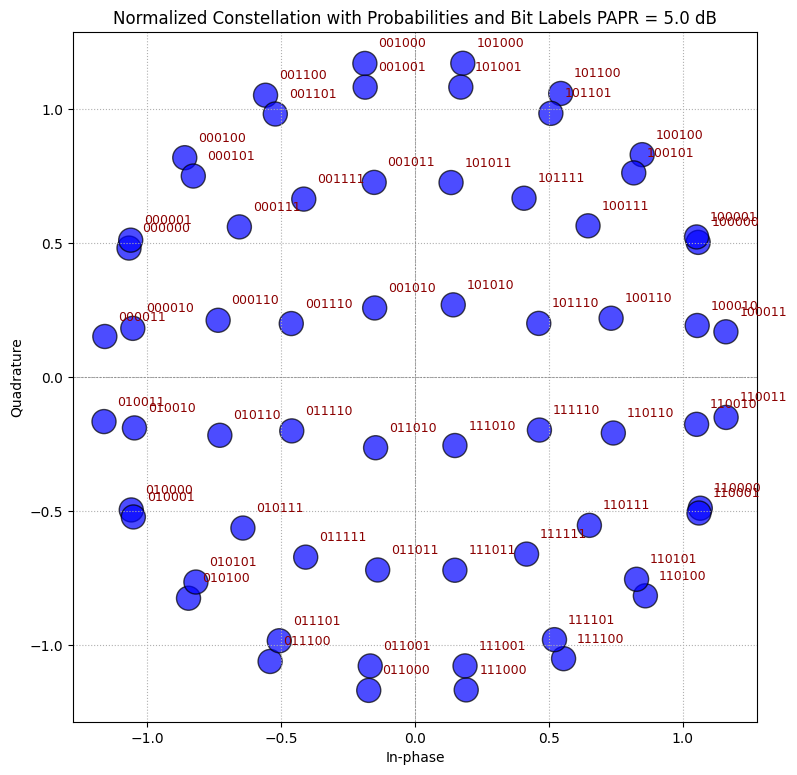

6.0
6.0
[0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625
 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625
 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625
 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625
 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625
 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625
 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625
 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625]
[-1.068331  +0.48145646j -1.0620551 +0.51100653j -1.0542067 +0.18162611j
 -1.1585909 +0.15128928j -0.8601649 +0.8189442j  -0.82830864+0.75043774j
 -0.73550814+0.2117792j  -0.65624166+0.56054384j -0.18755591+1.1709182j
 -0.18647043+1.0823956j  -0.15096316+0.2577759j  -0.15282096+0.72674745j
 -0.558451  +1.0522372j  -0.5220484 +0.9820892j  -0.46241337+0.1995652j
 -0.41573182+0.66432023j -1.0599364 -0.49642

<Figure size 640x480 with 0 Axes>

In [15]:
ebno_db = tf.random.uniform(shape=[1], minval=5.8, maxval=6.0)

# ebno_db = tf.convert_to_tensor([5.0])5

No = sn.phy.utils.ebnodb2no(ebno_db, num_bits_per_symbol=3.6, coderate=1)
No = tf.expand_dims(No, axis=-1)

with tf.GradientTape(persistent=False) as tape:
#     tape.watch(model.trainable_variables)  # Ensure variables are watched if needed, but no gradients will be calculated
    _,_,_,shaping_probs, norm_C_points, shaping_probs_basic = model(ebno_db, No)

# Define constellation points (complex numbers)
points = norm_C_points.numpy().flatten()
# points = x_mod.numpy().flatten()

# Define probabilities for each point
probabilities = shaping_probs.numpy().flatten()
basic_probabilities = shaping_probs_basic.numpy().flatten()

# plt.savefig('const.pdf')

# Normalize the constellation
normalized_points = normalize_constellation(points, probabilities)

title = "Normalized Constellation with Probabilities and Bit Labels PAPR = "+str(papr_threshold_db)+" dB"

# Plot the constellation
plot_constellation_wlabels(normalized_points, probabilities, title)
def entropy(pdf, base=2):
    pdf = np.asarray(pdf, dtype=np.float64)
    pdf = pdf[pdf > 0]  # remove zero entries to avoid log(0)
    pdf /= np.sum(pdf)  # normalize to ensure valid probability distribution

    H = -np.sum(pdf * np.log(pdf) / np.log(base))
    return H

print(entropy(basic_probabilities))
print(entropy(probabilities))

print(basic_probabilities)
print(normalized_points)
# print(model.sampling.P0.numpy())

## For Testing

In [17]:
###############################
# Testing random sequences in PAPR function
###############################
N = 64
num_bits_symbol = np.log2(N)
constellation_orig = Constellation("pam", num_bits_per_symbol=6)
tau = 10
parity_k = 0
use_upsampling_filtering = True

device = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"
model = EndToEndSystem_bitwise_PAS(N, parity_k, symbol_points_qam64, device, constellation_orig, use_upsampling_filtering, tau)
batch_size = 1000

ebno_db = tf.random.uniform(shape=[batch_size], minval=7.0, maxval=7.2)
No = sn.phy.utils.ebnodb2no(ebno_db, num_bits_per_symbol=num_bits_symbol, coderate=1)
No = tf.expand_dims(No, axis=-1)

_, _, _,_, norm_C_points,_  = model(ebno_db, No)

power_samples, x_power, x_up_power, x_tx_filt_power, p_x = model.test_sample_values(batch_size, 80, norm_C_points)



device /GPU:0


/home/harindu/anaconda3/envs/myenvtf/lib/python3.10/site-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'sampling_sym_sub_constellation_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/home/harindu/anaconda3/envs/myenvtf/lib/python3.10/site-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'end_to_end_system_bitwise_pas_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


PAPR: 3.594779372215271 dB
Mean power 1.0197622


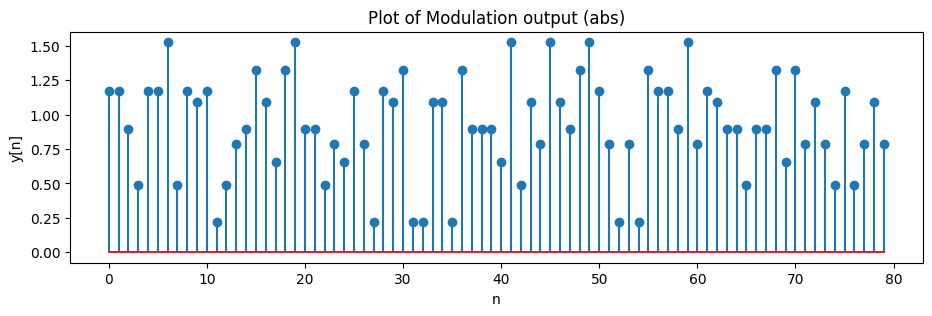

In [6]:
import matplotlib.pyplot as plt

x_power_np = x_power.numpy()
x_values = np.arange(x_power_np.shape[1])
plt.figure(figsize=(11, 3))
plt.xlabel('n')
plt.ylabel('y[n]')
plt.title(r'Plot of Modulation output (abs)')
plt.stem(x_values, np.abs(x_power_np[0,:]))

papr = np.max(np.abs(x_power_np[0:20,:])**2) / np.mean(np.abs(x_power_np[0:20,:])**2)
print("PAPR:", 10*np.log10(papr),'dB')
print("Mean power", np.mean(np.abs(x_power_np[0:20,:])**2))



In [7]:
# print(model.tx_filter.coefficients)
print(model.tx_filter.normalize)
tx_coeff = model.tx_filter.coefficients.numpy()
print(np.sum(np.abs(tx_coeff)**2))

True
3.999977


<StemContainer object of 3 artists>

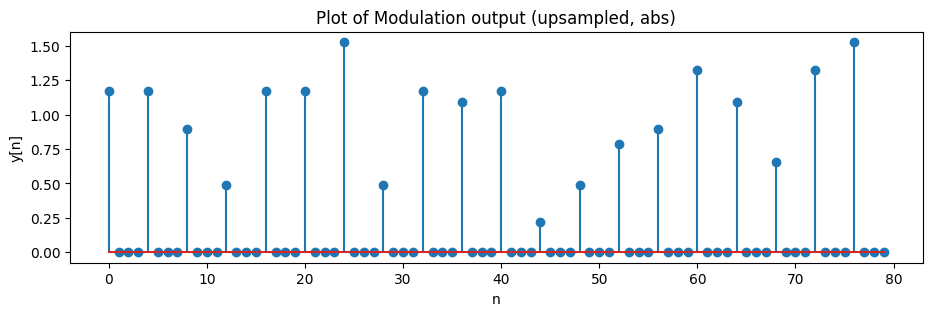

In [8]:
x_up_power_np = x_up_power.numpy()
x_values = np.arange(x_up_power_np.shape[1])
plt.figure(figsize=(11, 3))
plt.xlabel('n')
plt.ylabel('y[n]')
plt.title(r'Plot of Modulation output (upsampled, abs)')
plt.stem(x_values[:80], np.abs(x_up_power_np[0,:80]))

PAPR w/Transcient: 8.810094594955444 dB
PAPR Real: 7.370458245277405 dB
Mean power per sample 0.23947956
Mean power per symbol remains the same!!!


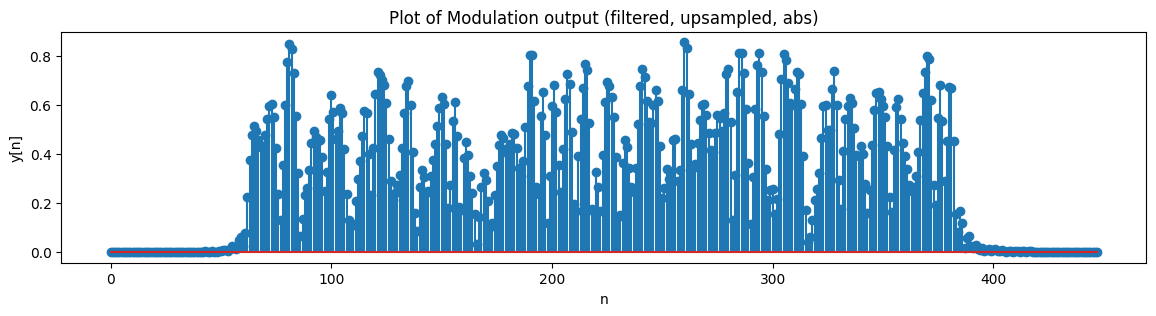

In [21]:
x_tx_filt_power_np = x_tx_filt_power.numpy()
x_values = np.arange(x_tx_filt_power_np.shape[1])
plt.figure(figsize=(14, 3))
plt.xlabel('n')
plt.ylabel('y[n]')
plt.title(r'Plot of Modulation output (filtered, upsampled, abs)')
plt.stem(x_values[:448], np.abs(x_tx_filt_power_np[0,-448:]))

papr = np.max(np.abs(x_tx_filt_power_np[:,:])**2) / np.mean(np.abs(x_tx_filt_power_np[:,:])**2)
print("PAPR w/Transcient:", 10*np.log10(papr),'dB')
papr = np.max(np.abs(x_tx_filt_power_np[:,64:-64])**2) / np.mean(np.abs(x_tx_filt_power_np[:,64:-64])**2)
print("PAPR Real:", 10*np.log10(papr),'dB')
print("Mean power per sample", np.mean(np.abs(x_tx_filt_power_np[0:20,100:300])**2))
print("Mean power per symbol remains the same!!!")

<StemContainer object of 3 artists>

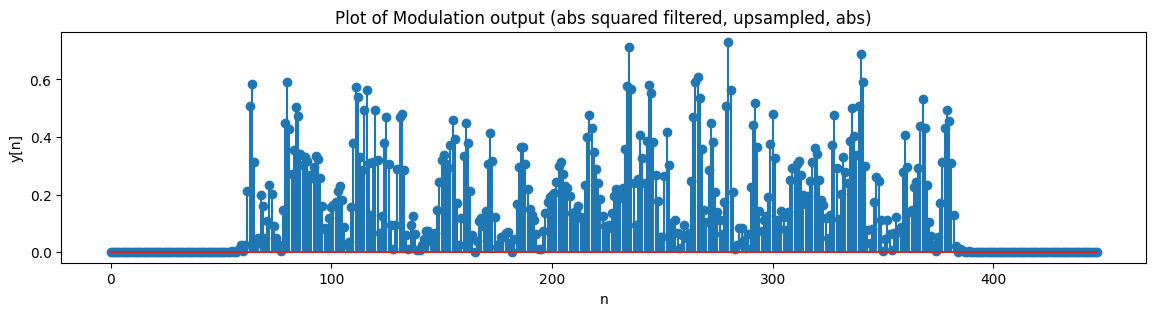

In [59]:
p_x_np = p_x.numpy()
x_values = np.arange(p_x_np.shape[1])
plt.figure(figsize=(14, 3))
plt.xlabel('n')
plt.ylabel('y[n]')
plt.title(r'Plot of Modulation output (abs squared filtered, upsampled, abs)')
plt.stem(x_values[:448], np.abs(p_x_np[0,:448]))